In [28]:
import numpy as np
import networkx as nx
import experiments
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import copy
matplotlib.rcParams['figure.figsize'] = (4.0,4.0)
matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 18.0
path = 'plots/'

In [2]:
n = 4039
g = experiments.AdjacencyListGraph(n, 'graphs/facebook_combined.txt')
M = g.get_adj_matrix()
G = nx.Graph(M)
graph_test = experiments.GNPGraph(30, 0.5)

In [3]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [4]:
comms = nx.community.greedy_modularity_communities(G)

In [35]:
attack_names = ['Inf 1 Rand', 'Def 1 Rand', 'Inf 1 Friend', 'Def 1 Friend', 
               'Inf 5 Rand', 'Inf 20 Rand', 'Def 5 Comm', 'Def 20 Comm', 
               'Inf+Def 5 Comm', 'Inf+Def 20 Comm', '2 Inf 5 Comm', '2 Def 5 Comm',
                'Inf 5 Def 5 Comm', '2 Inf 20 Comm', '2 Def 20 Comm', 'Inf 20 Def 20 Comm',
                'Def Big Comm']
attack_names_short = {attack_names[d]: 'A%d' % d for d in range(0, len(attack_names))}
def gen_attacks(n, n_mal, t1, t2, comm):
    attacks = []
    attacks.append( [[1, 0, n_mal-1, 'Random']])
    attacks.append( [[0, 1, n_mal, 'Random']])
    #an attack where no one is his friend
    attacks.append( [[1, 0, n_mal-1, 'Friends']])
    attacks.append( [[0, 1, n_mal, 'Friends']])
    
    #Try m = 1%, 5%, 10%, 15%, ..., 35%
    attacks.append( [[t1, 0, n_mal-t1, 'Random']] )
    attacks.append( [[t2, 0, n_mal-t2, 'Random']] )
    attacks.append( [[0, t1, n_mal-t1, comm]] )
    attacks.append( [[0, t2, n_mal-t2, comm]] )
    
    attacks.append( [[t1, t1, n_mal-t1, comm]] )
    attacks.append( [[t2, t2, n_mal-t2, comm]] )
    
    attacks.append( [[t1, 0, n_mal//2-t1, comm], [t1, 0, n_mal//2-t1, comm]] )
    attacks.append( [[0, t1, n_mal//2, comm], [0, t1, n_mal//2, comm]] )
    attacks.append( [[t1, 0, n_mal//2-t1, comm], [0, t1, n_mal//2, comm]] )
    attacks.append( [[t2, 0, n_mal//2-t2, comm], [t2, 0, n_mal//2-t2, comm]] )
    attacks.append( [[0, t2, n_mal//2, comm], [0, t2, n_mal//2, comm]] )
    attacks.append( [[t2, 0, n_mal//2-t2, comm], [0, t2, n_mal//2, comm]] )
    
    attacks.append( [[0, int((len(comm)-t1)*0.25), t1, comm]] )
    
    return attacks

In [36]:
def collect_data(attacks, attack_names, g, g_name, max_adv, epsilon, thresh_values, attack_values, reps):
    #labels = ['RR+Laplace, Response', 'RR+Laplace, Input', 'RR, Response', 'RR, Input', 'Naive, Response', 'Naive, Input']
    labels = ['RR+Laplace, Response', 'RR, Response', 'Naive, Response']
    E = [experiments.ResponseLaplaceManipulation(g, max_adv, epsilon, 1e-6, 0.1, [0.7, 0.5], [0.8, 0.5, 0.3]), 
         #experiments.InputLaplaceManipulation(g, max_adv, epsilon, 1e-6, 0.1, [0.7, 0.5], [0.8, 0.5, 0.3]),
         experiments.ResponseRRManipulation(g, max_adv, epsilon, 1e-6, [0.7], [0.8, 0.5]),
         #experiments.InputRRManipulation(g, max_adv, epsilon, 1e-6, [0.7], [0.8, 0.5]),
         experiments.ResponseRRNaiveManipulation(g, max_adv, epsilon, 1e-6, [0.7], [0.8, 0.5])
         #experiments.InputRRNaiveManipulation(g, max_adv, epsilon, 1e-6, [0.7], [0.8, 0.5])
        ]
    
    data = []
    for x in range(0, reps):
        for av in attack_values.keys():
            for a_i in range(0, len(attacks)):
                A = copy.deepcopy(attacks[a_i])
                if av == 'strong':
                    for a in A:
                        a[1] *= 3
                for i in range(0, len(E)):
                    E[i].reset_attacks()
                E[0].add_attacks(A)
                for i in range(1, len(E)):
                    E[i].set_attacks_like(E[0])
                for tv in thresh_values.keys():
                    for i in range(0, len(E)):
                        E[i].threshold_reduction = thresh_values[tv]
                        E[i].inflation_factors = attack_values[av]
                        d = E[i].get_results(False)
                        h = {'Protocol': labels[i], 'Attack': attack_names[a_i], 'Attack Strength': av, 'Threshold Strength': tv, 'Eps': epsilon, 'Graph': g_name,
                            'Mal Max Error': d[0][0], 'Mal L2 Error': d[0][1], 'Mal Mean Error': d[0][2], 'Mal T Nan': d[1][0], 'Mal T Tot': d[1][1], 'Mal Nan': d[2],
                            'Hon T Max Error': d[3][0], 'Hon T L2 Error': d[3][1], 'Hon T Mean Error': d[3][2], 'Hon T Nan': d[4][0], 'Hon T Tot': d[4][1],
                            'Rest Max Error': d[5][0], 'Rest L2 Error': d[5][1], 'Rest Mean Error': d[5][2], 'Rest Nan': d[6][0], 'Rest Tot': d[6][1]
                        }
                        data.append(h)
    return data

In [37]:
thresh_values = {'med': (0.9, 0.5, 0.5)}
attack_values = {'med': (0.1, 0.1), 'strong': (0.4, 0.4)}

In [38]:
atx = gen_attacks(g, 120, 5, 20, list(comms[1]))

In [33]:
%pdb

Automatic pdb calling has been turned ON


In [39]:
df = collect_data(atx, attack_names, g, 'FB', 120, 2.0, thresh_values, attack_values, 5)

In [10]:
import pickle
#pickle.dump(df, open('df1.pkl', 'wb'))
df = pickle.load(open('df1.pkl', 'rb'))

In [40]:
D = pd.DataFrame(df).drop('Graph', axis=1)

In [41]:
dat = D.groupby(['Protocol', 'Threshold Strength', 'Attack', 'Attack Strength']).mean()

In [42]:
#lab = dat.index.get_level_values('Protocol').unique()
lab = ['Naive, Response', 'RR, Response', 'RR+Laplace, Response']
attack = dat.index.get_level_values('Attack').unique()
attack_strength = dat.index.get_level_values('Attack Strength').unique()

In [43]:
inf_attack = [a for a in attack if 'Inf' in a]
def_attack = [a for a in attack if 'Def' in a]
best_inf_attacks = []
best_def_attacks = []
best_attacks = []

plots/fb_inf_strong.pdf
plots/fb_def_strong.pdf
plots/fb_tot_strong.pdf
plots/fb_inf_med.pdf
plots/fb_def_med.pdf
plots/fb_tot_med.pdf


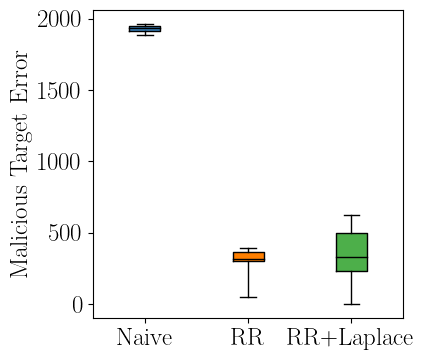

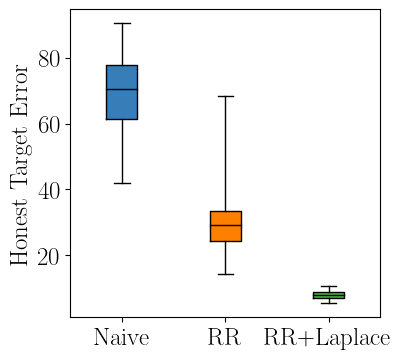

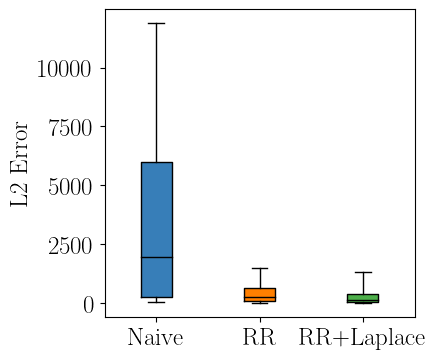

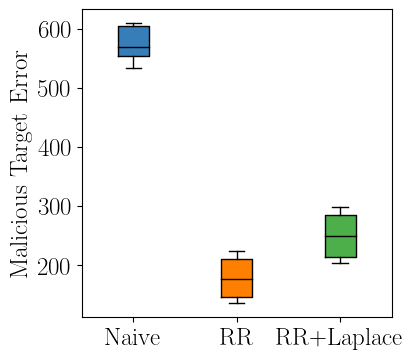

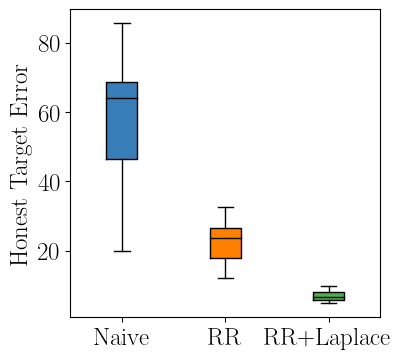

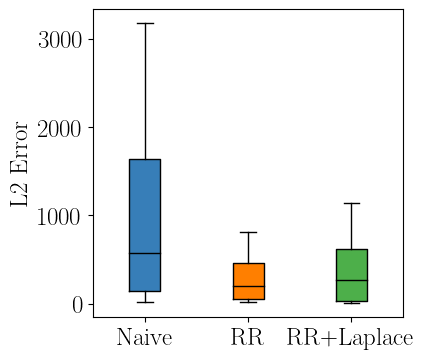

In [44]:

def plot_data(dat, attacks, s, err, y_lab, name):
    if isinstance(name, str):
        fig, ax = plt.subplots()
    else:
        ax = name
    graph_data = []
    for a in attacks:
        pts = []
        for p in lab:
            if err == 'rob':
                pts.append(dat.loc[p, 'med', a, s]['Mal Max Error'])
            elif err == 'acc':
                pts.append(dat.loc[p, 'med', a, s]['Hon T Max Error'])
            elif err == 'total':
                pts.append(np.sqrt(dat.loc[p, 'med', a, s]['Hon T L2 Error'] ** 2 + dat.loc[p, 'med', a, s]['Mal L2 Error'] ** 2))
        #ax.plot(pts, color=c, alpha=0.5)
        graph_data.append([a] + pts)
    PD = pd.DataFrame(graph_data).set_index(0)
    bplot = ax.boxplot(PD, labels=['Naive', 'RR', 'RR+Laplace'], whis=(0,100))
    for box, color in zip(bplot['boxes'], CB_color_cycle[0:3]):
        box_x = []
        box_y = []
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        ax.add_patch(matplotlib.patches.Polygon(box_coords, facecolor=color))
    for med in bplot['medians']:
        med.set_color('k')
    #pdb.set_trace()
    PD['metric 1'] = (PD[2] + PD[3]) / 2
    PD = PD.sort_values('metric 1')
    worst_attacks = PD.iloc[-2:, :]
    #ax.set_xticks([0,1,2], labels=['Naive', 'RR', 'RR+Laplace'])
    #pdb.set_trace()
    ax.set_ylabel(y_lab)
    if isinstance(name, str):
        print(name)
        plt.savefig(name, bbox_inches = "tight")
    return list(worst_attacks.index)

best_inf_attacks += plot_data(dat, inf_attack, 'strong', 'rob', 'Malicious Target Error', path + 'fb_inf_strong.pdf')
best_def_attacks += plot_data(dat, def_attack, 'strong', 'acc', 'Honest Target Error', path + 'fb_def_strong.pdf')
best_attacks += plot_data(dat, attack, 'strong', 'total', 'L2 Error', path + 'fb_tot_strong.pdf')
best_inf_attacks += plot_data(dat, inf_attack, 'med', 'rob', 'Malicious Target Error', path + 'fb_inf_med.pdf')
best_def_attacks += plot_data(dat, def_attack, 'med', 'acc', 'Honest Target Error', path + 'fb_def_med.pdf')
best_attacks += plot_data(dat, attack, 'med', 'total', 'L2 Error', path + 'fb_tot_med.pdf')

In [45]:
def get_honest_nans(dat):
    return dat.iloc[ np.where(dat['Hon T Nan'] + dat['Rest Nan'] > 0)[0] ]
get_honest_nans(dat)

,,,,Eps,Mal Max Error,Mal L2 Error,Mal Mean Error,Mal T Nan,Mal T Tot,Mal Nan,Hon T Max Error,Hon T L2 Error,Hon T Mean Error,Hon T Nan,Hon T Tot,Rest Max Error,Rest L2 Error,Rest Mean Error,Rest Nan,Rest Tot
Protocol,Threshold Strength,Attack,Attack Strength,,,,,,,,,,,,,,,,,


In [46]:
#How many malicious users are being caught in both strong and weak attacks?
def get_pct_disq(D):
    X = D.copy()
    X['PCT Disq'] = X['Mal T Nan'] / X['Mal T Tot']
    return X[['Protocol', 'Attack Strength', 'PCT Disq']].groupby(['Protocol', 'Attack Strength']).mean()['PCT Disq']
get_pct_disq(D)

Protocol              Attack Strength
Naive, Response       med                0.0000
                      strong             0.0000
RR+Laplace, Response  med                0.0000
                      strong             0.8680
RR, Response          med                0.0000
                      strong             0.5035
Name: PCT Disq, dtype: float64

## EuGraph

In [47]:
eu = experiments.AdjacencyListGraph(n, 'graphs/eucore/email-Eu-core.txt')
comms_eu = {}
with open('graphs/eucore/email-Eu-core-department-labels.txt') as f:
    for line in f:
        arr = line.split(' ')
        idx, c = int(arr[0]), int(arr[1])
        if c in comms_eu:
            comms_eu[c].append(idx)
        else:
            comms_eu[c] = [idx]

In [55]:
[(c, len(comms_eu[c])) for c in comms_eu]

[(1, 65),
 (21, 61),
 (25, 6),
 (14, 92),
 (9, 32),
 (26, 9),
 (4, 109),
 (17, 35),
 (34, 13),
 (11, 29),
 (5, 18),
 (10, 39),
 (36, 22),
 (37, 15),
 (7, 51),
 (22, 25),
 (8, 19),
 (15, 55),
 (3, 12),
 (29, 5),
 (20, 14),
 (16, 25),
 (38, 13),
 (27, 10),
 (13, 26),
 (6, 28),
 (0, 49),
 (28, 8),
 (2, 10),
 (40, 4),
 (35, 13),
 (23, 27),
 (19, 29),
 (24, 6),
 (32, 9),
 (31, 8),
 (39, 3),
 (12, 3),
 (30, 4),
 (41, 2),
 (18, 1),
 (33, 1)]

In [56]:
thresh_values = {'med': (1.0, 0.5, 0.5)}
attack_values = {'med': (0.10, 0.10), 'strong': (0.30, 0.30)}
atx_eu = gen_attacks(eu, 60, 5, 20, list(comms_eu[4]) + list(comms_eu[14]))

In [57]:
df_eu = collect_data(atx_eu, attack_names, eu, 'EU', 60, 2.0, thresh_values, attack_values, 5)

In [58]:
#pickle.dump(df_eu, open('df2.pkl', 'wb'))
df_eu = pickle.load(open('df2.pkl', 'rb'))

NameError: name 'pickle' is not defined

> /var/folders/16/n_zry7nd6lq5yjz8b66f969m0000gn/T/ipykernel_96141/1432945881.py(2)<module>()
      1 #pickle.dump(df_eu, open('df2.pkl', 'wb'))
----> 2 df_eu = pickle.load(open('df2.pkl', 'rb'))

ipdb> q


In [59]:
dat_eu = pd.DataFrame(df_eu).drop('Graph', axis=1)

In [60]:
dat_eu = dat_eu.groupby(['Protocol', 'Threshold Strength', 'Attack', 'Attack Strength']).mean()

plots/eu_inf_strong.pdf
plots/eu_def_strong.pdf
plots/eu_tot_strong.pdf
plots/eu_inf_med.pdf
plots/eu_def_med.pdf
plots/eu_tot_med.pdf


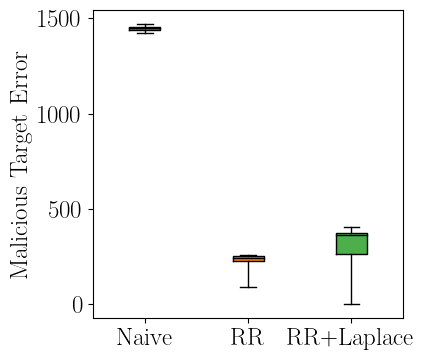

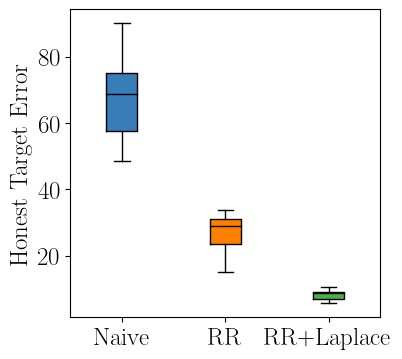

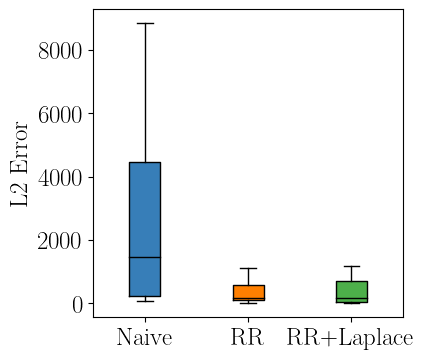

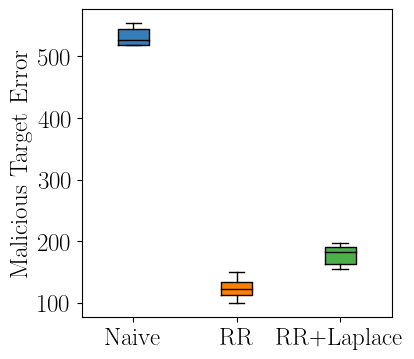

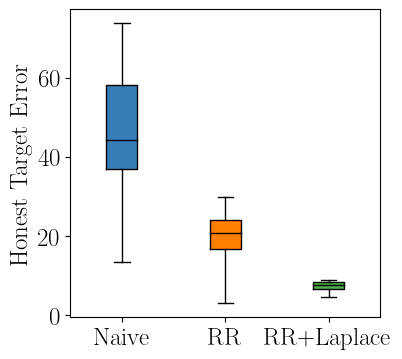

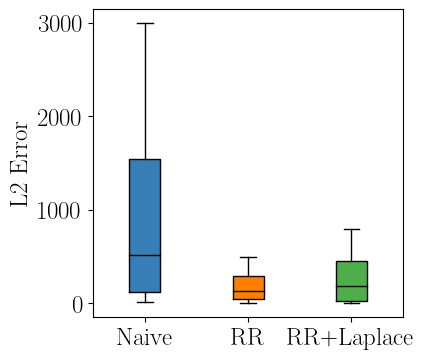

In [61]:
best_inf_attacks += plot_data(dat_eu, inf_attack, 'strong', 'rob', 'Malicious Target Error', path + 'eu_inf_strong.pdf')
best_def_attacks += plot_data(dat_eu, def_attack, 'strong', 'acc', 'Honest Target Error', path + 'eu_def_strong.pdf')
best_attacks += plot_data(dat_eu, attack, 'strong', 'total', 'L2 Error', path + 'eu_tot_strong.pdf')
best_inf_attacks += plot_data(dat_eu, inf_attack, 'med', 'rob', 'Malicious Target Error', path + 'eu_inf_med.pdf')
best_def_attacks += plot_data(dat_eu, def_attack, 'med', 'acc', 'Honest Target Error', path + 'eu_def_med.pdf')
best_attacks += plot_data(dat_eu, attack, 'med', 'total', 'L2 Error', path + 'eu_tot_med.pdf')

In [62]:
get_pct_disq(pd.DataFrame(df_eu))

Protocol              Attack Strength
Naive, Response       med                0.000
                      strong             0.000
RR+Laplace, Response  med                0.000
                      strong             0.704
RR, Response          med                0.000
                      strong             0.402
Name: PCT Disq, dtype: float64

In [63]:
get_honest_nans(dat_eu)

,,,,Eps,Mal Max Error,Mal L2 Error,Mal Mean Error,Mal T Nan,Mal T Tot,Mal Nan,Hon T Max Error,Hon T L2 Error,Hon T Mean Error,Hon T Nan,Hon T Tot,Rest Max Error,Rest L2 Error,Rest Mean Error,Rest Nan,Rest Tot
Protocol,Threshold Strength,Attack,Attack Strength,,,,,,,,,,,,,,,,,


In [64]:
dat.iloc[ np.where(dat_eu['Mal Nan'] > 0)]

,,,,Eps,Mal Max Error,Mal L2 Error,Mal Mean Error,Mal T Nan,Mal T Tot,Mal Nan,Hon T Max Error,Hon T L2 Error,Hon T Mean Error,Hon T Nan,Hon T Tot,Rest Max Error,Rest L2 Error,Rest Mean Error,Rest Nan,Rest Tot
Protocol,Threshold Strength,Attack,Attack Strength,,,,,,,,,,,,,,,,,
"RR+Laplace, Response",med,Inf 1 Friend,strong,2.0,228.603795,228.603795,228.603795,0.6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.666823,326.199371,5.024784,0.0,3919.0


In [65]:
gnp = experiments.GNPGraph(4000, 0.5)
comms_gnp = np.random.choice(range(0, 4000), 800, replace=False)

In [68]:
thresh_values = {'med': (0.9, 0.5, 0.5)}
attack_values = {'med': (0.10, 0.10), 'strong': (0.4, 0.4)}
atx_gnp = gen_attacks(gnp, 120, 5, 20, list(comms_gnp))

In [69]:
df_gnp = collect_data(atx_gnp, attack_names, gnp, 'GNP', 120, 2.0, thresh_values, attack_values, 5)

In [21]:
#pickle.dump(df_gnp, open('df3.pkl', 'wb'))
df_gnp = pickle.load(open('df3.pkl', 'rb'))

In [70]:
dat_gnp = pd.DataFrame(df_gnp).drop('Graph', axis=1)

In [71]:
dat_gnp = dat_gnp.groupby(['Protocol', 'Threshold Strength', 'Attack', 'Attack Strength']).mean()

plots/gnp_inf_strong.pdf
plots/gnp_def_strong.pdf
plots/gnp_tot_strong.pdf
plots/gnp_inf_med.pdf
plots/gnp_def_med.pdf
plots/gnp_tot_med.pdf


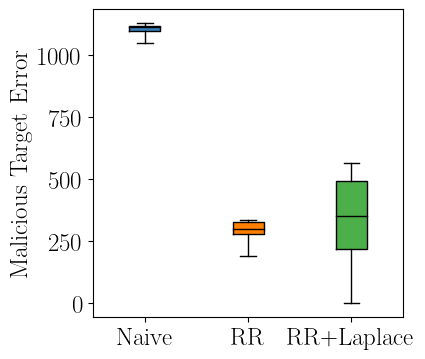

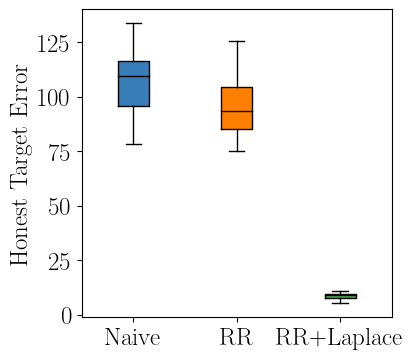

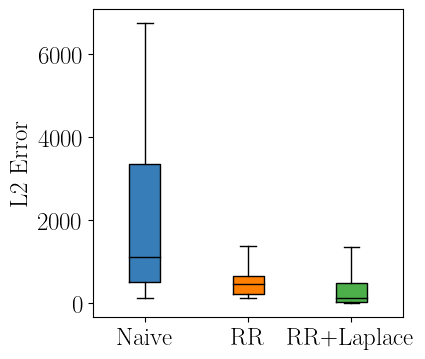

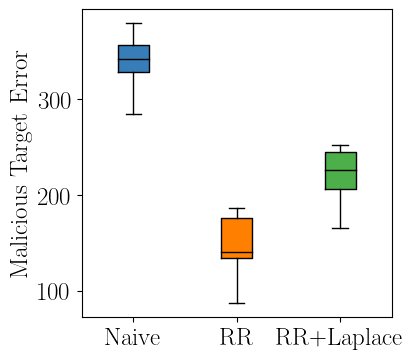

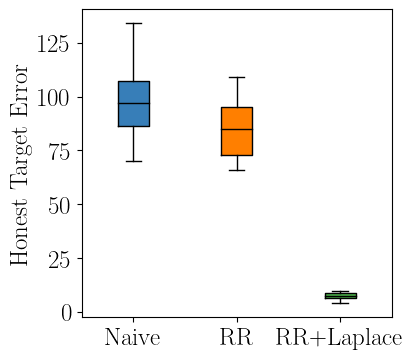

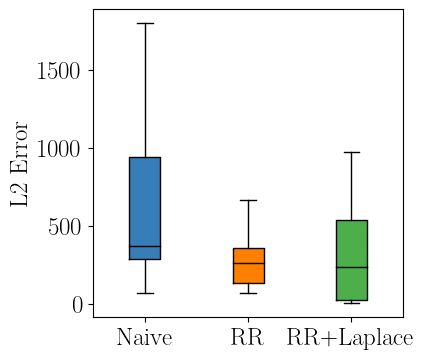

In [72]:
best_inf_attacks += plot_data(dat_gnp, inf_attack, 'strong', 'rob', 'Malicious Target Error', path + 'gnp_inf_strong.pdf')
best_def_attacks += plot_data(dat_gnp, def_attack, 'strong', 'acc', 'Honest Target Error', path + 'gnp_def_strong.pdf')
best_attacks += plot_data(dat_gnp, attack, 'strong', 'total', 'L2 Error', path + 'gnp_tot_strong.pdf')
best_inf_attacks += plot_data(dat_gnp, inf_attack, 'med', 'rob', 'Malicious Target Error', path + 'gnp_inf_med.pdf')
best_def_attacks += plot_data(dat_gnp, def_attack, 'med', 'acc', 'Honest Target Error', path + 'gnp_def_med.pdf')
best_attacks += plot_data(dat_gnp, attack, 'med', 'total', 'L2 Error', path + 'gnp_tot_med.pdf')

In [73]:
get_pct_disq(pd.DataFrame(df_gnp))

Protocol              Attack Strength
Naive, Response       med                0.000
                      strong             0.000
RR+Laplace, Response  med                0.000
                      strong             0.893
RR, Response          med                0.000
                      strong             0.363
Name: PCT Disq, dtype: float64

In [74]:
get_honest_nans(dat_gnp)

,,,,Eps,Mal Max Error,Mal L2 Error,Mal Mean Error,Mal T Nan,Mal T Tot,Mal Nan,Hon T Max Error,Hon T L2 Error,Hon T Mean Error,Hon T Nan,Hon T Tot,Rest Max Error,Rest L2 Error,Rest Mean Error,Rest Nan,Rest Tot
Protocol,Threshold Strength,Attack,Attack Strength,,,,,,,,,,,,,,,,,


In [75]:
dat_gnp.iloc[ np.where(dat_gnp['Mal Nan'] > 0)]

,,,,Eps,Mal Max Error,Mal L2 Error,Mal Mean Error,Mal T Nan,Mal T Tot,Mal Nan,Hon T Max Error,Hon T L2 Error,Hon T Mean Error,Hon T Nan,Hon T Tot,Rest Max Error,Rest L2 Error,Rest Mean Error,Rest Nan,Rest Tot
Protocol,Threshold Strength,Attack,Attack Strength,,,,,,,,,,,,,,,,,
"RR+Laplace, Response",med,Def Big Comm,strong,2.0,0.0,0.0,0.0,0.0,0.0,4.8,11.023583,126.439999,5.005738,0.0,594.0,12.530342,302.824837,5.003485,0.0,3401.0
"RR, Response",med,Def Big Comm,strong,2.0,0.0,0.0,0.0,0.0,0.0,5.0,86.280501,616.474047,20.152635,0.0,594.0,96.379949,1473.691744,20.118140,0.0,3401.0


In [76]:
attack_hist = {d: [0, 0, 0] for d in attack}

In [77]:
best_attacks_df = pd.value_counts(best_attacks)
best_inf_attacks_df = pd.value_counts(best_inf_attacks)
best_def_attacks_df = pd.value_counts(best_def_attacks)

In [78]:
for i in best_attacks_df.index:
    attack_hist[i][0] = best_attacks_df.loc[i]

for i in best_inf_attacks_df.index:
    attack_hist[i][1] = best_inf_attacks_df.loc[i]
    
for i in best_def_attacks_df.index:
    attack_hist[i][2] = best_def_attacks_df.loc[i]

In [79]:
L = np.array([attack_hist[a] for a in attack_names])

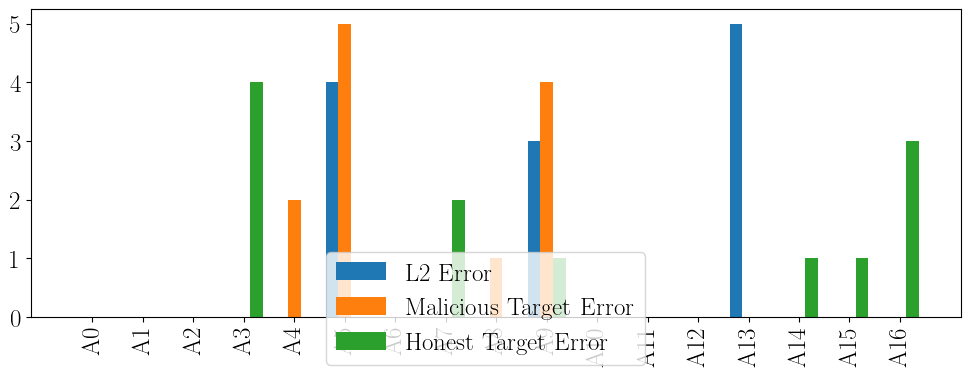

In [80]:
matplotlib.rcParams['figure.figsize'] = (12.0,4.0)
x = np.arange(0, len(attack), 1)
fig, ax = plt.subplots()
ax.bar(x, L[:, 0], width = 0.25, label = 'L2 Error')
ax.bar(x + .25, L[:, 1], width = 0.25, label = 'Malicious Target Error')
ax.bar(x + 0.5, L[:, 2], width = 0.25, label = 'Honest Target Error')
ax.set_xticks(x+0.25, [attack_names_short[a] for a in attack_names], rotation=90)
fig.legend(loc='outside lower center')
#ax.set_xticklabels(attack)

In [81]:
#A3, A5, A13
#Def 1 Friend, Inf 20 Rand, 2 Inf 20 Comm

In [82]:
attack_names_short

{'Inf 1 Rand': 'A0',
 'Def 1 Rand': 'A1',
 'Inf 1 Friend': 'A2',
 'Def 1 Friend': 'A3',
 'Inf 5 Rand': 'A4',
 'Inf 20 Rand': 'A5',
 'Def 5 Comm': 'A6',
 'Def 20 Comm': 'A7',
 'Inf+Def 5 Comm': 'A8',
 'Inf+Def 20 Comm': 'A9',
 '2 Inf 5 Comm': 'A10',
 '2 Def 5 Comm': 'A11',
 'Inf 5 Def 5 Comm': 'A12',
 '2 Inf 20 Comm': 'A13',
 '2 Def 20 Comm': 'A14',
 'Inf 20 Def 20 Comm': 'A15',
 'Def Big Comm': 'A16'}

In [44]:
D0 = pd.DataFrame(df)
D1 = pd.DataFrame(df_eu)
D2 = pd.DataFrame(df_gnp)

In [45]:
D1['Graph'] = 'EU'

In [46]:
D2.loc[D2['Mal Nan'] > 0, :]

,Protocol,Attack,Attack Strength,Threshold Strength,Eps,Graph,Mal Max Error,Mal L2 Error,Mal Mean Error,Mal T Nan,...,Hon T Max Error,Hon T L2 Error,Hon T Mean Error,Hon T Nan,Hon T Tot,Rest Max Error,Rest L2 Error,Rest Mean Error,Rest Nan,Rest Tot
103,"RR, Response",Def 50 Comm,med,med,2.0,GNP,0.0,0.0,0.0,0,...,102.788586,528.666681,20.836537,0,397,88.292868,1525.079500,20.430882,0,3598
108,"RR+Laplace, Response",Def Big Comm,med,med,2.0,GNP,0.0,0.0,0.0,0,...,11.407530,147.615375,5.056111,0,795,12.203580,292.704451,4.991738,0,3200
109,"RR, Response",Def Big Comm,med,med,2.0,GNP,0.0,0.0,0.0,0,...,80.827978,705.286301,19.778669,0,795,105.309997,1429.924506,20.328696,0,3200
111,"RR+Laplace, Response",Def Big Comm,strong,med,2.0,GNP,0.0,0.0,0.0,0,...,11.867896,145.846710,4.988778,0,795,11.190530,293.701299,5.006035,0,3200
112,"RR, Response",Def Big Comm,strong,med,2.0,GNP,0.0,0.0,0.0,0,...,78.553574,743.353696,20.914461,0,795,99.097249,1455.197670,20.472737,0,3200
222,"RR+Laplace, Response",Def Big Comm,med,med,2.0,GNP,0.0,0.0,0.0,0,...,12.879345,147.337910,5.034436,0,795,12.085285,292.578005,4.979705,0,3200
223,"RR, Response",Def Big Comm,med,med,2.0,GNP,0.0,0.0,0.0,0,...,92.744821,758.170878,21.497077,0,795,101.118750,1447.819296,20.494569,0,3200
225,"RR+Laplace, Response",Def Big Comm,strong,med,2.0,GNP,0.0,0.0,0.0,0,...,11.971029,148.574481,5.059850,0,795,12.860085,295.743511,5.028161,0,3200
226,"RR, Response",Def Big Comm,strong,med,2.0,GNP,0.0,0.0,0.0,0,...,95.658233,716.743809,20.672407,0,795,106.292868,1438.128764,20.318121,0,3200
336,"RR+Laplace, Response",Def Big Comm,med,med,2.0,GNP,0.0,0.0,0.0,0,...,11.642042,147.071288,5.023491,0,795,12.109387,291.450356,4.969734,0,3200


In [47]:
df_total = pd.concat((D0, D1, D2))

In [48]:
df_nan = df_total[['Protocol', 'Attack', 'Attack Strength', 'Mal T Nan', 'Mal Nan', 'Mal T Tot']]
df_nan = df_nan.groupby(['Protocol', 'Attack', 'Attack Strength']).mean()
#df_nan.columns = df_nan.columns.get_level_values(0)
df_nan.loc[:, 'Mal Nan Pct'] = df_nan.loc[:, 'Mal T Nan'] / df_nan.loc[:, 'Mal T Tot']

In [49]:
inf_df_nan = df_nan.loc[df_nan.loc[:, 'Mal T Tot'] > 0, :]

In [50]:
inf_df_nan.groupby(['Protocol', 'Attack Strength']).agg([np.mean, min, max])

Mal T Nan                      Mal Nan  \
                                          mean       min        max    mean   
Protocol             Attack Strength                                          
Naive, Response      med                  0.00  0.000000   0.000000     0.0   
                     strong               0.00  0.000000   0.000000     0.0   
RR+Laplace, Response med                  0.00  0.000000   0.000000     0.0   
                     strong              10.18  0.800000  31.466667     0.0   
RR, Response         med                  0.00  0.000000   0.000000     0.0   
                     strong               5.18  0.466667  12.866667     0.0   

                                               Mal T Tot             \
                                      min  max      mean  min   max   
Protocol             Attack Strength                                  
Naive, Response      med              0.0  0.0      12.7  1.0  40.0   
                     strong           0.0  0.0      12.7  1.0  40.0   
RR+Laplace, Response med              0.0  0.0      12.7  1.0  40.0   
                     strong           0.0  0.0      12.7  1.0  40.0   
RR, Response         med              0.0  0.0      12.7  1.0  40.0   
                     strong           0.0  0.0      12.7  1.0  40.0   

                                     Mal Nan Pct                      
                                            mean       min       max  
Protocol             Attack Strength                                  
Naive, Response      med                0.000000  0.000000  0.000000  
                     strong             0.000000  0.000000  0.000000  
RR+Laplace, Response med                0.000000  0.000000  0.000000  
                     strong             0.817333  0.766667  0.906667  
RR, Response         med                0.000000  0.000000  0.000000  
                     strong             0.455500  0.321667  0.586667

In [51]:
df_nan2 = df_total[['Protocol', 'Attack', 'Attack Strength', 'Graph', 'Mal T Nan', 'Mal Nan', 'Mal T Tot']]

In [52]:
df_nan2 = df_nan2.groupby(['Protocol', 'Attack', 'Attack Strength', 'Graph']).mean()

In [53]:
df_nan2[df_nan2['Mal Nan'] > 0]

Mal T Nan  Mal Nan  \
Protocol             Attack       Attack Strength Graph                       
RR+Laplace, Response Def Big Comm med             GNP          0.0      5.0   
                                  strong          GNP          0.0      5.0   
RR, Response         Def 50 Comm  med             GNP          0.0      0.2   
                                  strong          GNP          0.0      0.2   
                     Def Big Comm med             GNP          0.0      5.0   
                                  strong          GNP          0.0      5.0   

                                                         Mal T Tot  
Protocol             Attack       Attack Strength Graph             
RR+Laplace, Response Def Big Comm med             GNP          0.0  
                                  strong          GNP          0.0  
RR, Response         Def 50 Comm  med             GNP          0.0  
                                  strong          GNP          0.0  
                     Def Big Comm med             GNP          0.0  
                                  strong          GNP          0.0

# Effect of malicious users on graph size

In [54]:
n_mal = 120
t2 = 20
comm = comms
selected_attacks = []
selected_attacks.append( [(0, 1, n_mal, 'Friends')])

#selected_attacks.append( [(t1, 0, n_mal-t1, 'Random')] )
#selected_attacks.append( [(t2, 0, n_mal-t2, 'Random')] )

selected_attacks.append( [(t2, t2, n_mal-t2, comm)] )

selected_attacks.append( [(t2, 0, n_mal//2-t2, comm), (t2, 0, n_mal//2-t2, comm)] )


In [55]:
def collect_data_new(attack_names, g, g_name, max_adv, epsilons, thresh_values, attack_values, comm, reps):
    #labels = ['RR+Laplace, Response', 'RR+Laplace, Input', 'RR, Response', 'RR, Input', 'Naive, Response', 'Naive, Input']
    labels = ['RR+Laplace, Response', 'RR, Response', 'Naive, Response']
    E = [experiments.ResponseLaplaceManipulation(g, 2000, 1.0, 1e-6, 0.1, [0.7, 0.5], [0.8, 0.5, 0.3]), 
         experiments.ResponseRRManipulation(g, 2000, 1.0, 1e-6, [0.7], [0.8, 0.5]),
         experiments.ResponseRRNaiveManipulation(g, 2000, 1.0, 1e-6, [0.7], [0.8, 0.5])
        ]
    
    data = []
    max_adv = (g.get_dim() * np.array(max_adv)).astype(int)
    for x in range(0, reps):
        for n_mal in max_adv:
            t2 = int(n_mal // 6)
            attacks = [[(0, 1, n_mal, 'Friends')], [(t2, t2, n_mal-t2, list(comm))], [(t2, 0, n_mal//2-t2, list(comm)), (t2, 0, n_mal//2-t2, list(comm))]]
            #pdb.set_trace()
            for epsilon in epsilons:
                for exp in E:
                    exp.set_epsilon(epsilon)
                    exp.max_num_mal = n_mal
                for a_i in range(0, len(attacks)):
                    for i in range(0, len(E)):
                        E[i].reset_attacks()
                    E[0].add_attacks(attacks[a_i])
                    for i in range(1, len(E)):
                        E[i].set_attacks_like(E[0])

                    for av in attack_values.keys():
                        for tv in thresh_values.keys():
                            for i in range(0, len(E)):
                                E[i].threshold_reduction = thresh_values[tv]
                                E[i].inflation_factors = attack_values[av]
                                d = E[i].get_results(False)
                                h = {'Protocol': labels[i], 'Attack': attack_names[a_i], 'Attack Strength': av, 'Threshold Strength': tv, 'Eps': epsilon, 'Graph': g_name,
                                    'Mal Max Error': d[0][0], 'Mal L2 Error': d[0][1], 'Mal Mean Error': d[0][2], 'Mal T Nan': d[1][0], 'Mal T Tot': d[1][1], 'Mal Nan': d[2],
                                    'Num Mal': n_mal, 'Hon T Max Error': d[3][0], 'Hon T L2 Error': d[3][1], 'Hon T Mean Error': d[3][2], 'Hon T Nan': d[4][0], 'Hon T Tot': d[4][1],
                                    'Rest Max Error': d[5][0], 'Rest L2 Error': d[5][1], 'Rest Mean Error': d[5][2], 'Rest Nan': d[6][0], 'Rest Tot': d[6][1]
                                }
                                data.append(h)
    return data

In [37]:
# TODO: Fix comms, and how do thresh values and attack values work?
data_vary_n_mal = collect_data_new(['Def 1 Friend','Inf+Def Comm','2 Inf Comm'], g, 'FB', [0.01, 0.02, 0.03, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30], [2.0], thresh_values, {'med': (0.1, 0.1)}, list(comms[1]) + list(comms[0]), 15)

In [38]:
data_vary_n_mal = pd.DataFrame(data_vary_n_mal).drop(['Attack Strength', 'Threshold Strength', 'Eps'], axis=1)

In [39]:
DF = data_vary_n_mal.groupby(['Protocol', 'Attack', 'Graph', 'Num Mal']).mean()

In [40]:
DF.index.get_level_values(3)

Index([  40,   80,  121,  201,  403,  605,  807, 1009, 1211,   40,   80,  121,
        201,  403,  605,  807, 1009, 1211,   40,   80,  121,  201,  403,  605,
        807, 1009, 1211,   40,   80,  121,  201,  403,  605,  807, 1009, 1211,
         40,   80,  121,  201,  403,  605,  807, 1009, 1211,   40,   80,  121,
        201,  403,  605,  807, 1009, 1211,   40,   80,  121,  201,  403,  605,
        807, 1009, 1211,   40,   80,  121,  201,  403,  605,  807, 1009, 1211,
         40,   80,  121,  201,  403,  605,  807, 1009, 1211],
      dtype='int64', name='Num Mal')

In [41]:
DF

Mal Max Error  Mal L2 Error  \
Protocol        Attack       Graph Num Mal                                
Naive, Response 2 Inf Comm   FB    40          517.101939   1646.048648   
                                   80          540.757951   2508.347009   
                                   121         553.248913   3171.880989   
                                   201         590.921101   4317.578927   
                                   403         660.210669   6924.093908   
...                                                   ...           ...   
RR, Response    Inf+Def Comm FB    403         509.874620   3911.420950   
                                   605         727.252432   6903.712370   
                                   807         941.104458  10428.835728   
                                   1009       1154.821376  14399.224962   
                                   1211       1372.389293  18766.911187   

                                            Mal Mean Error  Mal T Nan  \
Protocol        Attack       Graph Num Mal                              
Naive, Response 2 Inf Comm   FB    40           474.610696        0.0   
                                   80           491.300811        0.0   
                                   121          500.919127        0.0   
                                   201          530.856500        0.0   
                                   403          597.619681        0.0   
...                                                    ...        ...   
RR, Response    Inf+Def Comm FB    403          477.545169        0.0   
                                   605          690.164540        0.0   
                                   807          900.639431        0.0   
                                   1009        1110.554721        0.0   
                                   1211        1323.345458        0.0   

                                            Mal T Tot  Mal Nan  \
Protocol        Attack       Graph Num Mal                       
Naive, Response 2 Inf Comm   FB    40            12.0      0.0   
                                   80            26.0      0.0   
                                   121           40.0      0.0   
                                   201           66.0      0.0   
                                   403          134.0      0.0   
...                                               ...      ...   
RR, Response    Inf+Def Comm FB    403           67.0      0.0   
                                   605          100.0      0.0   
                                   807          134.0      0.0   
                                   1009         168.0      0.0   
                                   1211         201.0      0.0   

                                            Hon T Max Error  Hon T L2 Error  \
Protocol        Attack       Graph Num Mal                                    
Naive, Response 2 Inf Comm   FB    40              0.000000        0.000000   
                                   80              0.000000        0.000000   
                                   121             0.000000        0.000000   
                                   201             0.000000        0.000000   
                                   403             0.000000        0.000000   
...                                                     ...             ...   
RR, Response    Inf+Def Comm FB    403            47.919254      156.676806   
                                   605            90.372343      274.469942   
                                   807           111.586360      399.073484   
                                   1009          124.597020      536.869399   
                                   1211          251.580205      769.382479   

                                            Hon T Mean Error  Hon T Nan  \
Protocol        Attack       Graph Num Mal                                
Naive, Response 2 Inf Comm   FB    40               0.000000        0.0   
      

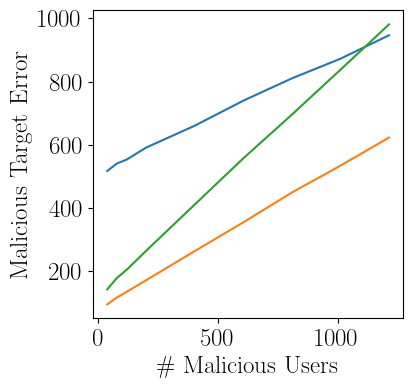

In [109]:
fig, ax = plt.subplots()
P1 = DF.loc['Naive, Response', '2 Inf Comm', 'FB', :]
ax.plot(list(P1.index), P1['Mal Max Error'])
P2 = DF.loc['RR, Response', '2 Inf Comm', 'FB', :]
ax.plot(list(P2.index), P2['Mal Max Error'])
P3 = DF.loc['RR+Laplace, Response', '2 Inf Comm', 'FB', :]
ax.plot(list(P3.index), P3['Mal Max Error'])
ax.set_xlabel('\# Malicious Users')
ax.set_ylabel('Malicious Target Error')
plt.savefig(path+'fb_inf_vary_nmal.pdf', bbox_inches = "tight")
#Add asymptote for naive.

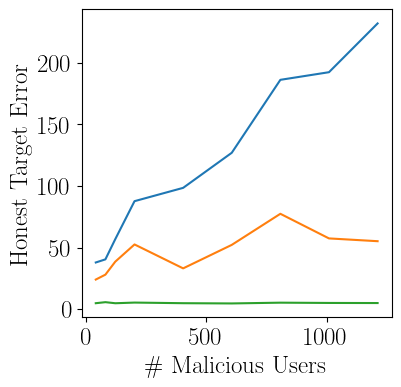

In [104]:
fig, ax = plt.subplots()
P1 = DF.loc['Naive, Response', 'Def 1 Friend', 'FB', :]
ax.plot(list(P1.index), P1['Hon T Max Error'])
P2 = DF.loc['RR, Response', 'Def 1 Friend', 'FB', :]
ax.plot(list(P2.index), P2['Hon T Max Error'])
P3 = DF.loc['RR+Laplace, Response', 'Def 1 Friend', 'FB', :]
ax.plot(list(P3.index), P3['Hon T Max Error'])
ax.set_xlabel('\# Malicious Users')
ax.set_ylabel('Honest Target Error')
plt.savefig(path+'fb_def_vary_nmal.pdf', bbox_inches = "tight")

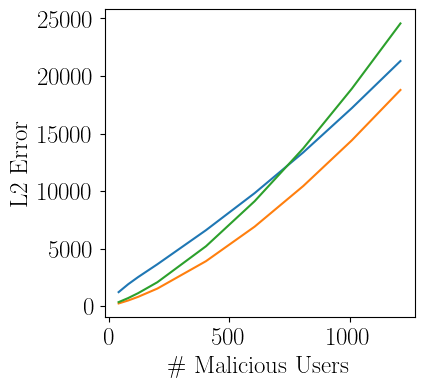

In [105]:
#Either L1 error or convert to scatter plot
fig, ax = plt.subplots()
P1 = DF.loc['Naive, Response', 'Inf+Def Comm', 'FB', :]
ax.plot(list(P1.index), np.sqrt(P1['Hon T L2 Error']**2 + P1['Mal L2 Error']**2))
P2 = DF.loc['RR, Response', 'Inf+Def Comm', 'FB', :]
ax.plot(list(P2.index), np.sqrt(P2['Hon T L2 Error']**2 + P2['Mal L2 Error']**2))
P3 = DF.loc['RR+Laplace, Response', 'Inf+Def Comm', 'FB', :]
ax.plot(list(P3.index), np.sqrt(P3['Hon T L2 Error']**2 + P3['Mal L2 Error']**2))
ax.set_xlabel('\# Malicious Users')
ax.set_ylabel('L2 Error')
plt.savefig(path+'fb_l2_vary_nmal.pdf', bbox_inches = "tight")

### Varying Epsilon

In [95]:
data_vary_eps = collect_data_new(['Def 1 Friend','Inf+Def Comm','2 Inf Comm'], g, 'FB', [0.03], [0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0], thresh_values, {'med': (0.1, 0.1)}, list(comms[1]) + list(comms[0]), 10)

KeyboardInterrupt: 

In [57]:
data_vary_eps = pd.DataFrame(data_vary_eps)

In [58]:
DF2 = data_vary_eps.drop(['Threshold Strength', 'Attack Strength'], axis=1)

In [59]:
DF2 = DF2.groupby(['Protocol', 'Attack', 'Graph', 'Eps']).mean()

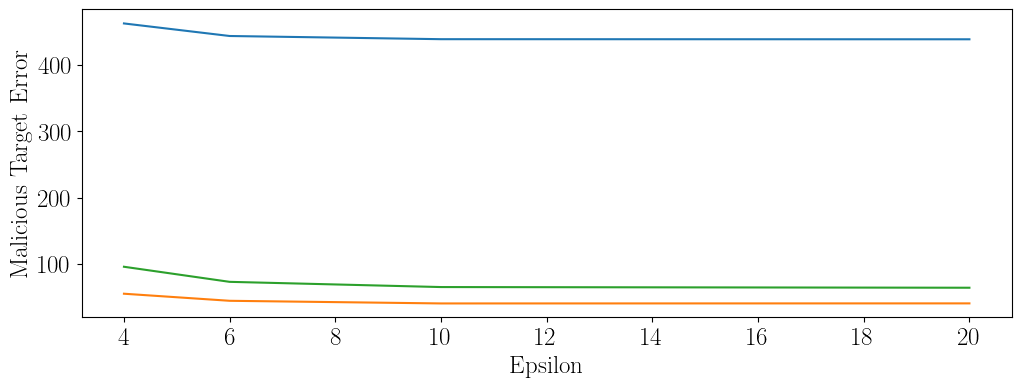

In [60]:
#Why is this not approaching 120?
fig, ax = plt.subplots()
P1 = DF2.loc['Naive, Response', '2 Inf Comm', 'FB', :]
ax.plot(list(P1.index), P1['Mal Max Error'])
P2 = DF2.loc['RR, Response', '2 Inf Comm', 'FB', :]
ax.plot(list(P2.index), P2['Mal Max Error'])
P3 = DF2.loc['RR+Laplace, Response', '2 Inf Comm', 'FB', :]
ax.plot(list(P3.index), P3['Mal Max Error'])
ax.set_xlabel('Epsilon')
ax.set_ylabel('Malicious Target Error')
plt.savefig(path+'fb_inf_vary_eps.pdf', bbox_inches = "tight")

In [68]:
E = experiments.ResponseRRManipulation(g, 120, 20.0, 1e-6, [0.1], [0.8, 0.5])
E.add_attacks()

In [70]:
E.get_results()

Malicious Target Error:
	0/0 Disqualified
Honest Target Error:
	0/0 Disqualified
Honest Error:
	0.00 (max), 0.00 (l_2), 0.00 (mean)
	0/4039 Disqualified


((0, 0, 0),
 (0, 0),
 0,
 (0, 0, 0),
 (0, 0),
 (4.307811195758404e-06, 1.7876828994174457e-05, 1.8010776645615894e-07),
 (0, 4039))

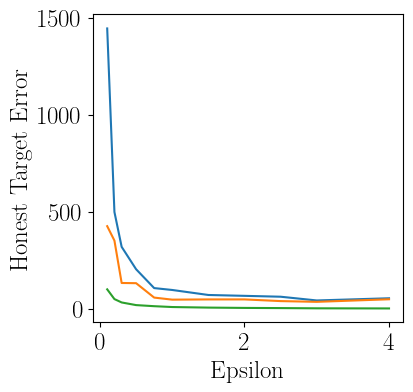

In [107]:
fig, ax = plt.subplots()
P1 = DF2.loc['Naive, Response', 'Def 1 Friend', 'FB', :]
ax.plot(list(P1.index), P1['Hon T Max Error'])
P2 = DF2.loc['RR, Response', 'Def 1 Friend', 'FB', :]
ax.plot(list(P2.index), P2['Hon T Max Error'])
P3 = DF2.loc['RR+Laplace, Response', 'Def 1 Friend', 'FB', :]
ax.plot(list(P3.index), P3['Hon T Max Error'])
ax.set_xlabel('Epsilon')
ax.set_ylabel('Honest Target Error')
plt.savefig(path+'fb_def_vary_eps.pdf', bbox_inches = "tight")

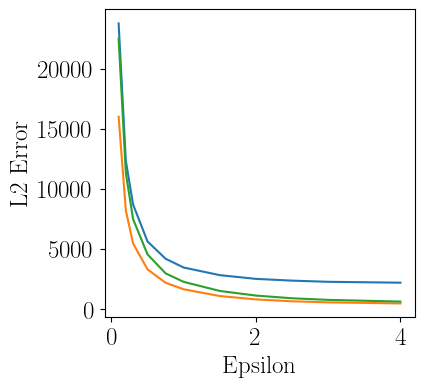

In [108]:
#Convert to scatter plot
#Add inflation attacks
fig, ax = plt.subplots()
P1 = DF2.loc['Naive, Response', 'Inf+Def Comm', 'FB', :]
ax.plot(list(P1.index), np.sqrt(P1['Hon T L2 Error']**2 + P1['Mal L2 Error']**2))
P2 = DF2.loc['RR, Response', 'Inf+Def Comm', 'FB', :]
ax.plot(list(P2.index), np.sqrt(P2['Hon T L2 Error']**2 + P2['Mal L2 Error']**2))
P3 = DF2.loc['RR+Laplace, Response', 'Inf+Def Comm', 'FB', :]
ax.plot(list(P3.index), np.sqrt(P3['Hon T L2 Error']**2 + P3['Mal L2 Error']**2))
ax.set_xlabel('Epsilon')
ax.set_ylabel('L2 Error')
plt.savefig(path+'fb_l2_vary_eps.pdf', bbox_inches = "tight")

### Varying Threshold

In [78]:
data_vary_thresh = collect_data_new(['Def 1 Friend','Inf+Def Comm','2 Inf Comm'], g, 'FB', [0.03], [2.0], {0: (1.5, 1.0, 1.0), 1: (1.0, 0.5, 0.5), 2: (0.8,0.4,0.4), 3: (0.6,0.3,0.3), 4: (0.5,0.25,0.25), 5: (0.4,0.2,0.2), 6: (0.3,0.15,0.15)}, {'strong': (0.4, 0.4)}, list(comms[1]) + list(comms[0]), 5)

In [79]:
data_vary_thresh = pd.DataFrame(data_vary_thresh)

In [80]:
DF3 = data_vary_thresh.drop(['Attack Strength'], axis=1)

In [81]:
DF3 = DF3.groupby(['Protocol', 'Attack', 'Graph', 'Threshold Strength']).mean()

In [82]:
# Honest users flagged vs % malicious users flagged scatter plot.
DF3.loc['RR, Response', '2 Inf Comm', 'FB', :]

,Eps,Mal Max Error,Mal L2 Error,Mal Mean Error,Mal T Nan,Mal T Tot,Mal Nan,Num Mal,Hon T Max Error,Hon T L2 Error,Hon T Mean Error,Hon T Nan,Hon T Tot,Rest Max Error,Rest L2 Error,Rest Mean Error,Rest Nan,Rest Tot
Threshold Strength,,,,,,,,,,,,,,,,,,
0,2.0,335.646574,1828.838167,288.234240,0.0,40.0,0.0,121.0,0.0,0.0,0.0,0.0,0.0,44.088232,695.731933,8.845219,0.0,3919.0
1,2.0,342.797858,1817.611541,289.212630,0.8,40.0,0.0,121.0,0.0,0.0,0.0,0.0,0.0,42.045097,696.305513,8.848048,0.0,3919.0
2,2.0,320.338865,588.710842,302.810433,35.8,40.0,0.0,121.0,0.0,0.0,0.0,0.0,0.0,48.138660,696.313072,8.798222,0.0,3919.0
3,2.0,0.000000,0.000000,0.000000,40.0,40.0,0.0,121.0,0.0,0.0,0.0,0.0,0.0,45.740578,696.522754,8.837537,0.2,3919.0
4,2.0,0.000000,0.000000,0.000000,40.0,40.0,0.0,121.0,0.0,0.0,0.0,0.0,0.0,44.677060,698.709899,8.837259,11.2,3919.0
5,2.0,0.000000,0.000000,0.000000,40.0,40.0,0.6,121.0,0.0,0.0,0.0,0.0,0.0,46.376015,683.604205,8.810096,98.4,3919.0
6,2.0,0.000000,0.000000,0.000000,40.0,40.0,3.6,121.0,0.0,0.0,0.0,0.0,0.0,42.303148,652.921742,8.815462,449.6,3919.0


In [70]:
fig, ax = plt.subplots()
P1 = DF3.loc['Naive, Response', '2 Inf Comm', 'FB', :]
ax.plot(list(P1.index), P1['Mal Max Error'])
P2 = DF3.loc['RR, Response', '2 Inf Comm', 'FB', :]
ax.plot(list(P2.index), P2['Mal Max Error'])
P3 = DF3.loc['RR+Laplace, Response', '2 Inf Comm', 'FB', :]
ax.plot(list(P3.index), P3['Mal Max Error'])

Eps  Mal Max Error  \
Protocol        Attack       Graph Threshold Strength                       
Naive, Response 2 Inf Comm   FB    0                   2.0    1013.993757   
                                   1                   2.0    1019.178341   
                                   2                   2.0    1006.627056   
                                   3                   2.0    1004.367686   
                                   4                   2.0    1013.018303   
...                                                    ...            ...   
RR, Response    Inf+Def Comm FB    2                   2.0     272.534104   
                                   3                   2.0     264.521925   
                                   4                   2.0     272.626207   
                                   5                   2.0     269.747807   
                                   6                   2.0     271.389671   

                                                       Mal L2 Error  \
Protocol        Attack       Graph Threshold Strength                 
Naive, Response 2 Inf Comm   FB    0                    6086.305290   
                                   1                    6078.062026   
                                   2                    6087.075140   
                                   3                    6071.365676   
                                   4                    6091.195564   
...                                                             ...   
RR, Response    Inf+Def Comm FB    2                    1062.210703   
                                   3                    1071.020499   
                                   4                    1069.244851   
                                   5                    1025.512510   
                                   6                     968.116537   

                                                       Mal Mean Error  \
Protocol        Attack       Graph Threshold Strength                   
Naive, Response 2 Inf Comm   FB    0                       962.083810   
                                   1                       960.731384   
                                   2                       962.182288   
                                   3                       959.740042   
                                   4                       962.819110   
...                                                               ...   
RR, Response    Inf+Def Comm FB    2                       236.952257   
                                   3                       239.013722   
                                   4                       238.659203   
                                   5                       237.494950   
                                   6                       238.563105   

                                                       Mal T Nan  Mal T Tot  \
Protocol        Attack       Graph Threshold Strength                         
Naive, Response 2 Inf Comm   FB    0                         0.0       40.0   
                                   1                         0.0       40.0   
                                   2                         0.0       40.0   
                                   3                         0.0       40.0   
                                   4                         0.0       40.0   
...                                                          ...        ...   
RR, Response    Inf+Def Comm FB    2                         0.0       20.0   
                                   3                         0.0       20.0   
                                   4                         0.0       20.0   
                                   5                         1.4       20.0   
                                   6                         3.6       20.0   

                                                       Mal Nan  Num Mal  \
Protocol        Attack       Graph Threshold Strength                     
N